In [1]:
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import statistics
from mtcnn import MTCNN
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
landmarks_faces_df = pd.read_csv('outputs\oversampled_faces_with_landmarks_mediapipe.csv')
#parse the landmarks column to a list of tuples
landmarks_faces_df['landmarks'] = landmarks_faces_df['landmarks'].apply(eval)

In [4]:
#Displays the rows with duplicate paths to validate code above works
landmarks_faces_df[landmarks_faces_df.duplicated(subset='pth', keep=False)].sort_values(by='pth')

,index,pth,label,landmarks
4242,4244,augmented/ffhq_1027.png,happy,"[(0.5089619755744934, 0.731025218963623, -0.04..."
6522,6526,augmented/ffhq_1027.png,sad,"[(0.5089619755744934, 0.731025218963623, -0.04..."
3646,3648,augmented/ffhq_1031.png,happy,"[(0.5259443521499634, 0.678326427936554, -0.03..."
6290,6294,augmented/ffhq_1031.png,sad,"[(0.5259443521499634, 0.678326427936554, -0.03..."
3902,3904,augmented/ffhq_1042.png,happy,"[(0.4635147452354431, 0.7055484056472778, -0.0..."
...,...,...,...,...
16715,16741,oversampled/image0042251.jpg,neutral,"[(0.5246935486793518, 0.7083243727684021, -0.0..."
12593,12616,oversampled/image0042343.jpg,anger,"[(0.43755483627319336, 0.8306260704994202, -0...."
12815,12838,oversampled/image0042343.jpg,anger,"[(0.43755483627319336, 0.8306260704994202, -0...."
16460,16486,oversampled/image0042515.jpg,neutral,"[(0.45101094245910645, 0.6387134194374084, -0...."


In [7]:
model_training_df = landmarks_faces_df[['pth', 'label','landmarks']]
model_training_df.reset_index(inplace=True, drop=True)
model_training_df

,pth,label,landmarks
0,anger/image0001956.jpg,happy,"[(0.5075767636299133, 0.6905035972595215, -0.0..."
1,anger/image0004504.jpg,happy,"[(0.506913423538208, 0.6853656768798828, -0.05..."
2,anger/image0006510.jpg,happy,"[(0.5290422439575195, 0.6751238107681274, -0.0..."
3,anger/image0009562.jpg,happy,"[(0.5999926328659058, 0.7471040487289429, -0.0..."
4,anger/image0012970.jpg,happy,"[(0.4938056170940399, 0.7192921042442322, -0.0..."
...,...,...,...
35324,mirrored/oversampled_ffhq_2310.png,neutral,"[(0.5659758448600769, 0.704839289188385, -0.04..."
35325,mirrored/oversampled_ffhq_5002.png,neutral,"[(0.4660402238368988, 0.702263593673706, -0.05..."
35326,mirrored/oversampled_ffhq_2838.png,neutral,"[(0.46601274609565735, 0.7176843881607056, -0...."
35327,mirrored/oversampled_ffhq_4807.png,neutral,"[(0.553207278251648, 0.6844416856765747, -0.08..."


https://github.com/k-m-irfan/simplified_mediapipe_face_landmarks?fbclid=IwAR22kX7xW6mVog_PtG-vvt1aluhH-7RfvikCWVfGDoD19hHBHyPejvZaMGE

In [8]:
left_eyebrow = [70,63,105,66,107,55,65,52,53,46]
right_eyebrow = [300,293,334,296,336,285,295,282,283,276]
left_eye = [33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7]
right_eye =  [263,466,388,387,386,385,384,398,362,382,381,380,374,373,390,249]
inner_lip = [78,191,80,81,82,13,312,311,310,415,308,324,318,402,317,14,87,178,88,95]
outer_lip =  [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146]
face_boundary = [10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109]
left_iris = [468,469,470,471,472]
right_iris = [473,474,475,476,477]
nose = [64,4,294]

combined_points = []
combined_points.extend(left_eyebrow)
combined_points.extend(right_eyebrow)
combined_points.extend(left_eye)
combined_points.extend(right_eye)
combined_points.extend(inner_lip)
combined_points.extend(outer_lip)
combined_points.extend(face_boundary)
combined_points.extend(left_iris)
combined_points.extend(right_iris)
combined_points.extend(nose)

In [9]:
for row in model_training_df.iterrows():
    landmarks = row[1]['landmarks']
    landmarks = [landmarks[i] for i in combined_points]
    model_training_df.at[row[0], 'landmarks'] = landmarks

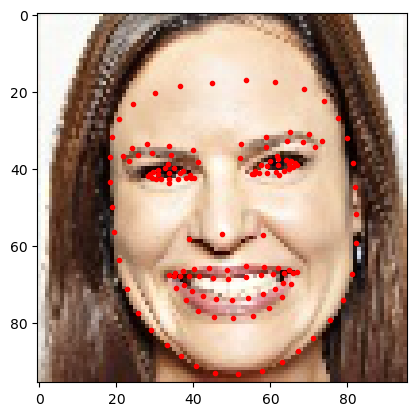

In [10]:
# Load the image
image_path = "./dataset/" + model_training_df['pth'][0]
image = mpimg.imread(image_path)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Get the landmarks
landmarks = model_training_df['landmarks'][0]

# Plot the landmarks as points
for landmark in landmarks:
    x, y, _ = landmark
    ax.plot(x * 96, y * 96, 'ro', markersize=3)

# Show the plot
plt.show()


#display the resulting coordinates of each landmark

In [11]:
# Extract x, y, and z coordinates from the tuples in the 'landmarks' column
coordinates = model_training_df['landmarks'].apply(lambda x: [coord for landmark in x for coord in landmark])

# Create a DataFrame from the extracted coordinates
landmarks_df = pd.DataFrame(coordinates.tolist(), columns=[f'lm_{i+1}_{coord}' for i in range(len(coordinates.iloc[0]) // 3) for coord in ['x', 'y', 'z']])

# Concatenate the original DataFrame with the new landmarks DataFrame
model_training_df = pd.concat([model_training_df, landmarks_df], axis=1)

# Drop the original 'landmarks' column
model_training_df.drop(columns=['landmarks', 'pth'], inplace=True)
model_training_df.head()

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
0,happy,0.226219,0.381799,0.038242,0.250068,0.361314,-0.008271,0.292014,0.350517,-0.044980,...,-0.007774,0.403663,0.608458,-0.067300,0.493527,0.593167,-0.181729,0.604648,0.596916,-0.079903
1,happy,0.246005,0.348122,-0.051194,0.283079,0.332501,-0.078546,0.327581,0.327949,-0.095936,...,0.030347,0.432196,0.600044,-0.079112,0.533977,0.598784,-0.150699,0.580798,0.609539,-0.042294
2,happy,0.257999,0.383563,0.002389,0.283292,0.362782,-0.032297,0.322953,0.348970,-0.058516,...,0.001229,0.444767,0.598483,-0.056526,0.518412,0.577950,-0.142952,0.589326,0.579395,-0.052673
3,happy,0.207841,0.427158,-0.052541,0.249446,0.397158,-0.077840,0.304518,0.374407,-0.092454,...,0.072984,0.479263,0.637998,-0.092606,0.610292,0.589869,-0.167392,0.666678,0.605170,-0.038013
4,happy,0.244650,0.352717,0.059794,0.270829,0.328296,0.025753,0.314433,0.316996,-0.002371,...,0.028702,0.417333,0.594563,-0.060003,0.505565,0.570643,-0.153477,0.597533,0.610524,-0.062293


In [12]:
model_training_df.to_csv('outputs/simplified_landmarks.csv', index=False, header=True, encoding='utf-8')

In [13]:
#Splitting of data into train and test sets, 
train_set = model_training_df.sample(frac=0.8)
train_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
23944,sad,0.212664,0.434860,-0.050450,0.248348,0.405287,-0.078691,0.295306,0.380192,-0.094404,...,0.049171,0.444320,0.653066,-0.077518,0.550138,0.608731,-0.152481,0.609995,0.619583,-0.033217
27991,anger,0.217285,0.327329,0.044605,0.249606,0.307888,0.012840,0.296066,0.296895,-0.012243,...,0.039255,0.394838,0.577825,-0.064793,0.494459,0.556515,-0.154232,0.575226,0.581182,-0.056264
23011,sad,0.217922,0.353019,0.070997,0.230521,0.330159,0.017558,0.261036,0.317839,-0.030263,...,-0.044421,0.430371,0.647992,-0.044010,0.488073,0.618814,-0.174422,0.600906,0.632148,-0.078423
6860,sad,0.281063,0.381256,-0.037319,0.318169,0.361654,-0.062979,0.366289,0.352179,-0.079111,...,0.039382,0.436778,0.632705,-0.065918,0.539149,0.619471,-0.132995,0.581690,0.645591,-0.029613
7249,sad,0.231337,0.357151,0.063672,0.254930,0.343321,0.022453,0.292657,0.338109,-0.011862,...,-0.000961,0.378549,0.579215,-0.048894,0.452806,0.559986,-0.152826,0.537078,0.595571,-0.065625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12307,anger,0.263326,0.465268,0.052468,0.279538,0.435400,0.028494,0.309255,0.414332,0.008210,...,0.038501,0.464395,0.621640,-0.062958,0.519985,0.566620,-0.132318,0.589212,0.584628,-0.058204
23548,sad,0.244648,0.331498,0.057276,0.271910,0.308331,0.020777,0.314897,0.296341,-0.009260,...,0.021094,0.405464,0.600243,-0.057201,0.493177,0.576724,-0.149973,0.575833,0.609860,-0.058720
3947,happy,0.273303,0.463565,0.068386,0.286963,0.438576,0.033116,0.314800,0.421561,0.001777,...,0.000226,0.434748,0.635037,-0.050881,0.497498,0.603755,-0.144743,0.590599,0.603386,-0.069319
13695,neutral,0.277328,0.386173,0.034028,0.296523,0.366004,-0.003832,0.328518,0.359154,-0.036377,...,0.000285,0.421486,0.633705,-0.038312,0.481297,0.613082,-0.130693,0.562578,0.635853,-0.052889


In [14]:
test_set = pd.concat([model_training_df,train_set]).drop_duplicates(keep=False)
test_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
2,happy,0.257999,0.383563,0.002389,0.283292,0.362782,-0.032297,0.322953,0.348970,-0.058516,...,0.001229,0.444767,0.598483,-0.056526,0.518412,0.577950,-0.142952,0.589326,0.579395,-0.052673
11,happy,0.282253,0.397349,-0.028642,0.300388,0.386589,-0.064933,0.330824,0.386955,-0.094734,...,-0.041174,0.422601,0.649090,-0.035052,0.484339,0.656519,-0.120428,0.556651,0.648746,-0.039090
13,happy,0.258242,0.379813,0.009708,0.282656,0.356962,-0.026476,0.320692,0.348820,-0.058481,...,-0.021388,0.413151,0.622779,-0.052390,0.494023,0.613141,-0.144953,0.577083,0.620769,-0.060317
15,happy,0.221798,0.334395,-0.003371,0.250602,0.307004,-0.041484,0.298948,0.292374,-0.070419,...,0.009754,0.424747,0.605174,-0.065478,0.528478,0.588356,-0.159651,0.612554,0.601387,-0.051614
16,happy,0.250935,0.355763,-0.007931,0.280926,0.337461,-0.043914,0.324523,0.327115,-0.069436,...,0.002890,0.417247,0.606256,-0.056156,0.506806,0.593717,-0.145801,0.583188,0.613328,-0.048423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35296,neutral,0.191135,0.237120,0.031330,0.228589,0.213849,-0.017328,0.280645,0.208135,-0.056963,...,0.004447,0.348511,0.617055,-0.068857,0.444250,0.595785,-0.192212,0.536449,0.650053,-0.069122
35304,neutral,0.264686,0.455834,0.023847,0.282105,0.435464,-0.011506,0.312633,0.421638,-0.040356,...,-0.003943,0.451395,0.625757,-0.048200,0.512291,0.597729,-0.137514,0.582184,0.602987,-0.052370
35306,neutral,0.286792,0.410484,0.006486,0.310216,0.395450,-0.024308,0.344077,0.389096,-0.048833,...,0.000353,0.436912,0.614890,-0.042814,0.493253,0.598257,-0.120417,0.546521,0.617015,-0.040647
35322,neutral,0.267603,0.436940,0.046024,0.288332,0.410100,0.022081,0.322501,0.392111,0.002444,...,0.044757,0.449140,0.617655,-0.055787,0.506478,0.570890,-0.122772,0.564335,0.607856,-0.043967


In [17]:
# Exporting Datasets
train_set.to_csv('outputs/train_set_augmented_simplified.csv', index=False, header=True, encoding='utf-8')

In [18]:
# Exporting Datasets
test_set.to_csv('outputs/test_set_augmented_simplified.csv', index=False, header=True, encoding='utf-8')